# Assortative Matching

The focus while modelling the spread of infectious diseases with sid is on how people get in contact with each other. There are two types of contacts:

1. Recurrent contacts like household members, close friends, collegues, class mates, etc. which are met in frequently or with certainty.
2. Non-recurrent contacts like clients or customers at work, members of your sports groups, etc.. which are more infrequent and random contacts.

This notebook focuses on the second group of contacts and how they can be modeled using assortative matching. Though, the contacts are non-recurrent it does not mean that meeting one of two different people is equiprobable. Assortative matching means that individuals meet each other based on underlying characteristics. For example, age is a strong assortative variable because people in the same age groups are likely to share the same needs and interests and meet in the same places.

Assortative matching can be weaker and stronger. Working in a grocery store or discounter leads to contacts with a variety of people and, thus, assortative matching is weaker. If one goes to the church service one is more likely to encounter elderly people. Bars are more frequented by younger adults.

What is the effect of assortative matching on the spread of an infectious disease? To study this question, we will employ a simple simulation exercise with the following key factors.

- We will simulate the spread of a disease in a sample of 100,000 people for one and a half year.
- The people are grouped into 5,000 groups which means there are 20 people in one group.
- We start with 10 initially infected people which are randomly drawn.
- People meet one person each period which is either from her own group or one of the others.
- The parameter to control the assortative matching is the probability that a person meets someone from his own group. The remaining probabably is distributed equally among the other groups. For example, if a person meets an individual from her own group with 50% chance, the probability for each other group is $\frac{1 - 0.5}{4999} \approx 0.00002$.
- We set the infection probability to 20% which is the chance of a transmition if an infected and an susceptible person meet.

What are our intuitions?

1. Let us focus on the extreme scenarios.

    - If all people meet only members of their own group (strong assortative matching), the disease will quickly die out. The disease will be completely contained in the groups where an initial infection exists. It is likely that all members of the group will get the disease.
    - If there is no assortative matching at all, all contacts are equiprobable and there is no containment effect. The disease will spread out and likely infect all people until the dynamics of herd immunity set in.
    
2. Thus, there are two forces playing against each other in moderate scenarios.

    - Stronger assortative matching makes the disease spread more quickly in groups. But, at some turning point the probability of meeting someone in the same group which has not been infected yet becomes more and more unlikely. The disease will slowly spread to groups without initial infections.
    - In the case of weak assortative matching, the disease will quickly spread over the whole population without affecting some subgroups harder than the rest.
    
Now, let us turn to the simulation which is only briefly commented. First, some import statements.

In [1]:
import io

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sid

Here, we create the artificial data set with 100,000 individuals in 5,000 groups á 20 persons. The age group is arbitrarily chosen and only affects the course of the disease, but not the transmission process.

In [2]:
n_individuals = 100_000
n_groups = 5_000

initial_states = pd.DataFrame(
    {
        "id": np.arange(n_individuals),
        "group": np.repeat(np.arange(n_groups), n_individuals // n_groups),
        "age_group": "20 - 29",
    }
).astype({"group": "category", "age_group": "category"})

There are ten initially infected people randomly spread over the population.

In [3]:
n_initially_infected = 10

initial_infections = pd.Series(index=initial_states.index, data=False)
indices = np.random.choice(len(initial_infections), size=n_initially_infected)
initial_infections.iloc[indices] = True

Here, we define the contact model. Each person meets one other person each period.

In [4]:
n_contacts_per_individual = 1


def meet_people(states, params):
    return pd.Series(index=states.index, data=n_contacts_per_individual)


contact_models = {
    "meet_people": {"model": meet_people, "assort_by": "group", "is_recurrent": False}
}

We take the default parameters and set the probability for the assortative matching to 10% and the infection probability to 20%. The latter will remain constant during the study.

In [5]:
index_columns = ["category", "subcategory", "name"]
params = pd.read_csv("../../../sid/params.csv", index_col=index_columns)

additional_params = """
category,subcategory,name,value
assortative_matching,meet_people,group,0.1
infection_prob,meet_people,,0.2
"""
additional_params = pd.read_csv(
    io.StringIO(additional_params), index_col=index_columns,
)

params = params.append(additional_params).sort_index()

additional_params

,,,value
category,subcategory,name,
assortative_matching,meet_people,group,0.1
infection_prob,meet_people,NaN,0.2


Here, we run the simulation and vary the parameter for the assortative matching from $0.1, 0.2, ..., 1$.

In [6]:
assortative_matching_params = [1 / n_groups] + np.linspace(0.1, 1, 10).tolist()

newly_infected = []
for value in assortative_matching_params:
    # Change assortative matching in params.
    params.loc[("assortative_matching", "meet_people", "group"), "value"] = value

    # Simulate the data.
    df = sid.simulate(
        params=params,
        initial_states=initial_states,
        initial_infections=initial_infections,
        contact_models=contact_models,
        duration={"start": "2020-01-01", "end": "2021-6-30"},
        seed=0,
    )

    # Save newly infected.
    s = df.groupby(["date", "group"])["newly_infected"].sum().compute()
    newly_infected.append(s)

    # Remove reference to .parquet files on disk.
    del df

Now, let us visualize the spread of the disease. The following graph shows the number of newly infected people on a weekly-basis. Each curve represents a degree of assortative matching. For weaker assortative matching the curves peak rapidly between April and June.

In cases of stronger assortative matching, the curves flatten which has two implications. First, the current number of people needing care is lower, but, secondly, the duration of the pandemic is prolonged.

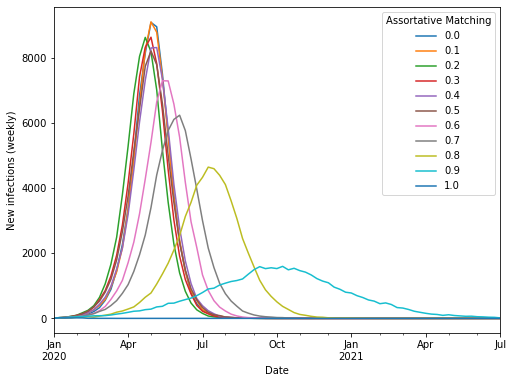

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))

for i, value in enumerate(assortative_matching_params):
    newly_infected[i].reset_index(level="group").resample("W").sum()[
        "newly_infected"
    ].plot(ax=ax, label=str(np.round(value, 2)))
    
plt.xlabel("Date")
plt.ylabel("New infections (weekly)")

plt.legend(title="Assortative Matching")
plt.show()